This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the interior variety of Douglas fir GEA mapping pops

- First I LD-prune SNPs to use for structure correction in baypass.
- Then I use LD-pruned SNPs to estimate the covariance matrix across 5 independent runs of the core mode of baypass, and to ensure convergence I calculate the pairwise correlation of the matrices across runs (I found that these runs were highly correlated, r2 > 0.998).
- Then I run baypass in STD mode (mcmc) for SNPs in our data.

In [16]:
from pythonimports import *

DIR = '/data/projects/pool_seq/DF_datasets'
snpdir = op.join(DIR, 'DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

# Choose SNPs for GEA structure correction in baypass

First choose loci for each variety (coastal and interior) then choose loci across both.

for SNPs with MAF > 0.05 and for all pops: 40 < DP < 1000, randomly choose one snp per contig (for contigs > 1Kbp), then LD prune so no pairwise r2 > 99.9th percentile of r2

#### get the snps

In [4]:
lview,dview = get_client()

56 56


In [54]:
def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

def get_skipto_df(f, skipto, nrows, cols=None, filter_maf=False, **kwargs):
    """Retrieve dataframe in parallel so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f after skipto
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    if filter_maf is True:
        return maf_filter(df, **kwargs)
    
    return df
dview['get_skipto_df'] = get_skipto_df

def filter_depth(*args):
    """Filter min/max depth, reduce columns."""
    chunk = get_skipto_df(*args)
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [6]:
snpdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI'

In [7]:
# get linenums for each variety and each type
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt 2609583


In [9]:
# filter for depth in parallel as I read it in
f = keys(linenums)[0]
nrows = 50000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(filter_depth, *(f, skipto, nrows)))
watch_async(jobs)

53
53


In [ ]:
# combine depth-filtered chunks into one df
snps = pd.concat([j.r for j in jobs])
print(snps.shape)
snps.head()

In [8]:
luni(snps['CHROM'])

27148

#### reduce those snps on contigs > 1Kbp

In [9]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [10]:
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [11]:
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((1216986, 45), (1219501, 88))

In [12]:
len(freqcols)

42

In [13]:
min(lens.values())

1001

46
46


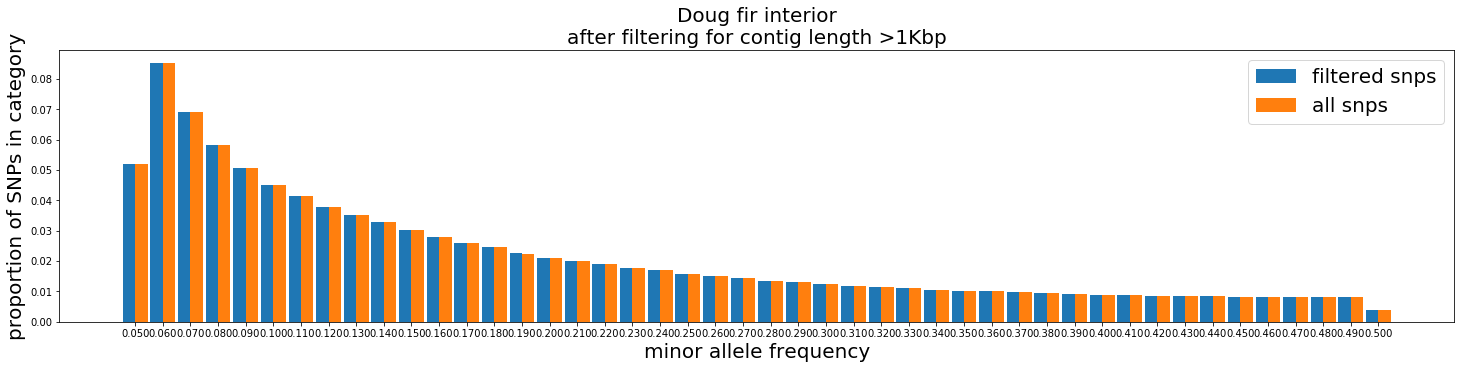

In [14]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for contig length >1Kbp')

#### reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

In [24]:
# def reduce_col(col):
#     """Return list of loci with no missing data for pop.FREQ col."""
#     return reduced[~reduced[col].isnull()].index

In [26]:
# # get loci from each pop without missing data
# reduce_col_outs = []
# for col in nb(freqcols):
#     reduce_col_outs.append(reduce_col(col))

100%|██████████| 42/42 [00:32<00:00,  1.29it/s]


In [29]:
# # combine returns to get loci with no missing data across pop.FREQ cols
# nomissingloci = snps.index.tolist()
# for out in nb(reduce_col_outs):
#     nomissingloci = list(set(nomissingloci).intersection(out))
# len(nomissingloci), luni(nomissingloci)

100%|██████████| 42/42 [00:16<00:00,  2.59it/s]


(370749, 370749)

In [30]:
# # reduce snp table to no missing loci
# reduced_nm = reduced[reduced.index.isin(nomissingloci)]
# reduced_nm.head()

,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p85.FREQ,DF_p86.FREQ,DF_p87.FREQ,DF_p88.FREQ,DF_p89.FREQ,DF_p9.FREQ,DF_p94.FREQ,CHROM,AF,MAF
jcf7190000000004-54643,32.14%,12.28%,25.93%,42.86%,36.36%,28.57%,25.86%,42.19%,48.48%,26.32%,30.95%,55.56%,29.63%,31.43%,54.17%,35.82%,30.3%,23.21%,47.46%,35.59%,15.38%,31.37%,8.7%,25%,16.13%,26.32%,39.29%,16.44%,32.56%,14.29%,13.33%,16.33%,41.1%,35.38%,58.14%,34.21%,29.55%,15.09%,37.5%,21.05%,42.86%,8.7%,jcf7190000000004,0.303347,0.303347
jcf7190000000004-54644,80.7%,96.55%,84.62%,90.32%,92.54%,89.47%,90%,77.78%,87.5%,92.31%,90.48%,90.48%,76.92%,73.53%,83.33%,83.58%,68.25%,77.78%,86.44%,82.14%,53.85%,78.85%,75.56%,100%,90.16%,83.33%,84.62%,85.14%,83.72%,34.48%,95.95%,81.63%,86.11%,69.7%,78.57%,95.95%,82.22%,90.57%,58.82%,77.19%,75%,80%,jcf7190000000004,0.817361,0.182639
jcf7190000000004-54700,87.5%,96.72%,85.29%,88.68%,89.86%,88.73%,85.29%,86.67%,92.31%,94.12%,87.5%,92.06%,80.77%,74.29%,71.43%,81.67%,80.77%,77.59%,86.36%,82.54%,52.38%,80.36%,68.89%,100%,90.41%,83.75%,78.43%,87.67%,83.33%,37.74%,91.3%,75.86%,84.62%,72.58%,80.56%,94.74%,76.79%,88.14%,55.88%,77.08%,77.19%,75.47%,jcf7190000000004,0.814210,0.185790
jcf7190000000004-55345,89.83%,95.71%,86.67%,91.18%,92.31%,89.47%,92%,77.78%,88.89%,94.23%,88.89%,79.41%,80%,71.05%,87.5%,78.43%,86.11%,75.41%,76.74%,82.46%,55.36%,79.1%,70%,100%,87.93%,89.61%,80.3%,85.54%,86.49%,22.97%,93.51%,74.29%,87.84%,75%,81.58%,82.89%,90.24%,79.07%,52.5%,80.43%,68%,78.72%,jcf7190000000004,0.809950,0.190050
jcf7190000000004-289701,61.64%,83.33%,79.41%,83.33%,86.13%,67.71%,78.26%,66.27%,90.48%,85.51%,76.71%,69.03%,71.88%,87.1%,78.57%,65.12%,64.35%,66.35%,72.86%,84.35%,49.18%,69.5%,69.62%,86.11%,68.97%,75.45%,64.22%,58.7%,79.1%,32.35%,79.22%,68.32%,85.91%,68.75%,86.42%,72.41%,72.48%,71.13%,60.22%,66.07%,69.86%,65.69%,jcf7190000000004,0.722703,0.277297


46
46


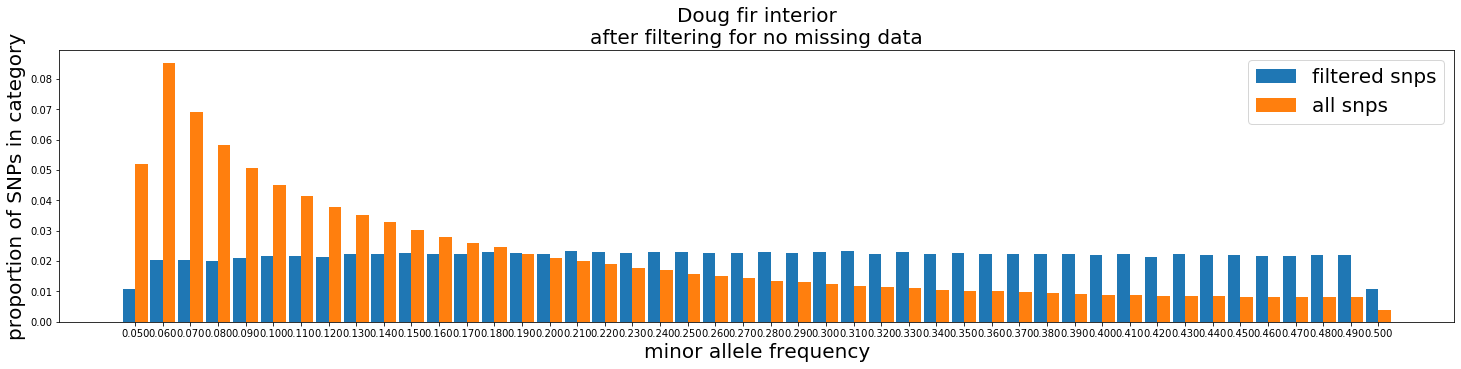

In [35]:
# # compare MAF spectrum between no-missing and precursor
# make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
#                  get_mafdict(snps['AF'], roundto=2),
#                  title='Doug fir interior\nafter filtering for no missing data')

#### try to reduce to X% missing data ... 

Result: any filtering resulted in a visibly different MAF spectrum

In [88]:
def filter_perc(df, perc=0.10):
    """Filter df for missing data below perc."""
    import pandas
    from tqdm.notebook import tqdm as tnb
    
    freqcols = [col for col in df.columns if '.FREQ' in col]
    keep = []
    for locus in tnb(df.index):
        if sum(df.loc[locus,:].isnull())/len(freqcols) <= perc:
            keep.append(locus)
    return keep

In [99]:
jobs = []
tosend = []
i = 0
for locus in tnb(reduced.index):
    tosend.append(locus)
    if len(tosend) == 21732 or (i+1)==nrow(reduced):
#         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :]))
        jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))
        tosend = []
    i += 1
watch_async(jobs)

56
56


In [100]:
perc_loci = []
for j in jobs:
    perc_loci.extend(j.r)
len(perc_loci)

1158566

46
46


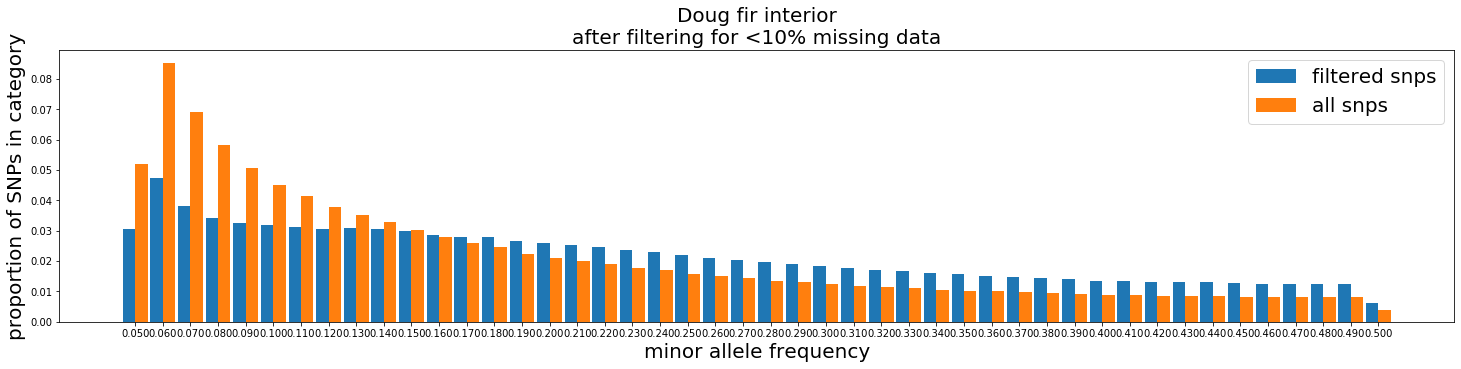

In [98]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for <10% missing data')

46
46


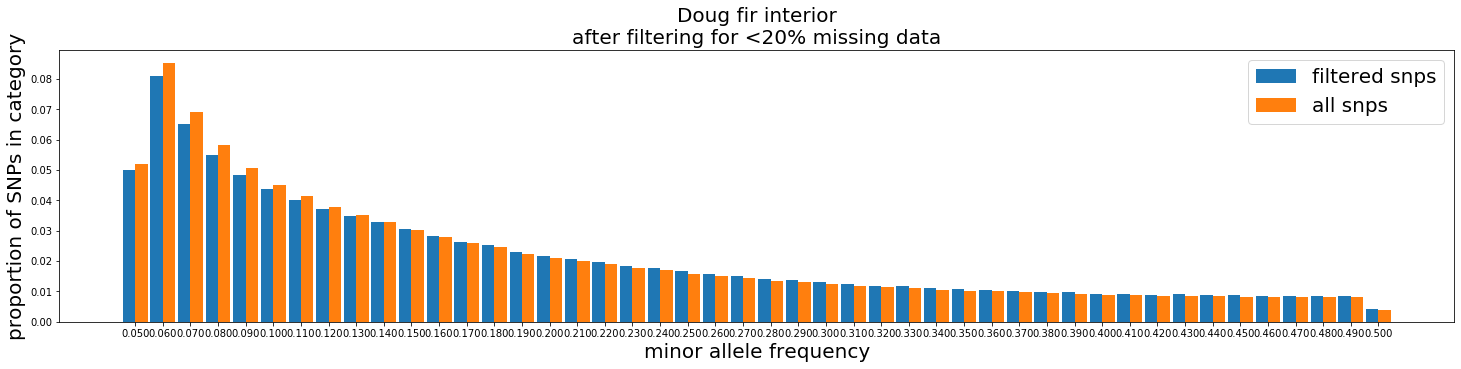

In [101]:
# compare MAF spectrum between no-missing and precursor
# MIGHT AS WELL KEEP LOCI WITHOUT FILTERING FOR MISSING DATA
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for <20% missing data')

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering < 25% missing data, the MAF spectrum looked weird, leaving the code inplace.

#### choose one snp per contig at random

In [15]:
len(lview)

56

In [16]:
def choose_random_loci(df):
    """For each chrom in df['CHROM'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['CHROM']):
        loci = df.loc[chrom, 'locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [17]:
# how many chroms do I send to a job? A: math.ceil(476.42)
luni(reduced['CHROM']), luni(reduced['CHROM'])/len(lview)

(26680, 476.42857142857144)

In [18]:
# change the index for easy sending
reduced['locus'] = reduced.index.tolist()
reduced.index = reduced['CHROM'].tolist()

In [19]:
nrow(reduced), luni(reduced['locus'])

(1216986, 1216986)

In [20]:
# choose random loci in parallel
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['CHROM'])
for chrom in tnb(uni(reduced['CHROM'])):
    tosend.append(chrom)
    if len(tosend) == 477 or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

56
56


In [21]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['CHROM'])

True

In [22]:
# reset index, reduce reduced to only randomloci
red = reduced[reduced['locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

26680 26680


,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p85.FREQ,DF_p86.FREQ,DF_p87.FREQ,DF_p88.FREQ,DF_p89.FREQ,DF_p9.FREQ,DF_p94.FREQ,CHROM,AF,MAF,locus
jcf7190000000004,4.94%,18.18%,8.33%,NaN,11.11%,16.67%,9.9%,10.71%,7.55%,4.82%,4.69%,6.72%,28%,NaN,22.22%,16.87%,5.34%,18%,9.72%,14.17%,1.55%,15.97%,NaN,12.93%,3.54%,6.84%,11.32%,2.48%,1.49%,0.99%,22.98%,8.04%,0.8%,NaN,NaN,7.84%,2.59%,7.14%,NaN,NaN,5%,10.31%,jcf7190000000004,0.097246,0.097246,jcf7190000000004-289808
jcf7190000000008,17.95%,17.39%,NaN,30.56%,9.52%,31.11%,22.86%,11.11%,NaN,60%,29.63%,16.98%,17.07%,21.21%,9.52%,28.21%,31.91%,42.42%,22.22%,30.3%,21.82%,22.73%,31.58%,17.31%,7.69%,40.62%,34%,27.08%,35.48%,28%,18.37%,48.08%,31.58%,14.29%,24.24%,36%,32.73%,22.5%,20%,37.04%,26.09%,34.78%,jcf7190000000008,0.265446,0.265446,jcf7190000000008-431360
jcf7190000000011,7.64%,11.51%,10.59%,9.12%,10.66%,11.33%,10.06%,12.03%,9.5%,10.98%,11.82%,10.09%,10.32%,8.03%,11.23%,7.79%,12.86%,8.33%,11.81%,10.67%,8.84%,12.16%,13.99%,11.35%,11.49%,12.85%,11.03%,12.01%,13.21%,6.04%,13.35%,11.98%,12.01%,11.85%,11.21%,12.21%,8.45%,14.03%,9.97%,10.93%,7.55%,6.91%,jcf7190000000011,0.107023,0.107023,jcf7190000000011-190688
jcf7190000000014,100%,100%,98.51%,100%,100%,98.85%,58.9%,0%,100%,100%,10.39%,0%,3.17%,65.22%,78.26%,0%,0%,34.34%,100%,100%,100%,0%,97.59%,100%,100%,100%,100%,100%,100%,0%,100%,100%,97.14%,66.13%,100%,78.47%,40.85%,71.43%,79.63%,58.62%,62.5%,100%,jcf7190000000014,0.711719,0.288281,jcf7190000000014-15050
jcf7190000000023,3.33%,5.63%,7.89%,15%,NaN,14.29%,7.27%,7.89%,5.88%,6.06%,9.09%,4.17%,NaN,NaN,13.79%,7.14%,6.98%,13.33%,10.26%,22.45%,9.3%,8.16%,10.29%,20%,15.56%,NaN,10.45%,NaN,8.51%,6.25%,5.45%,14.08%,NaN,17.74%,9.38%,13.79%,6.82%,34.29%,NaN,NaN,6.45%,NaN,jcf7190000000023,0.107936,0.107936,jcf7190000000023-30076


In [23]:
# reset index
reduced = red.copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(26680, 46)

46
46


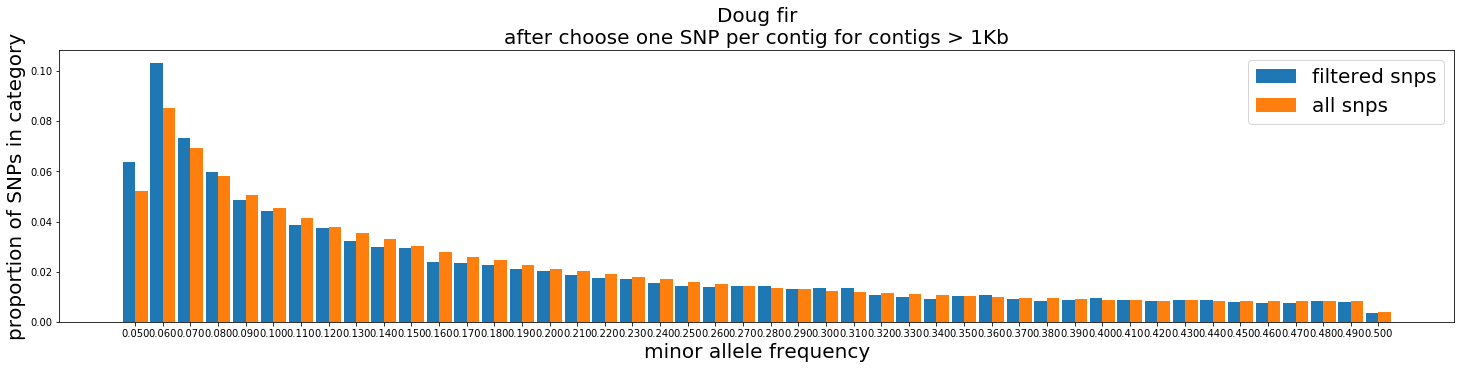

In [24]:
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

#### get an idea of r2 values so we can determine an empirical high-end cutoff

In [25]:
len(lview)

56

In [48]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [49]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)

112
112


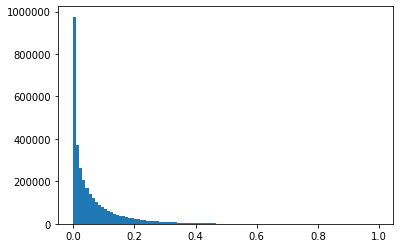

In [50]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [199]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.7045941368215466

In [198]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]

0.5642448902244581

In [200]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]

0.3875596557874945

In [51]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]

0.3247159221595135

In [52]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]

0.2866305675733651

In [204]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i)
        break
(i+1)/len(r2vals)

3071270


0.9263763211234979

In [290]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i)
        break
(i+1)/len(r2vals)

3229028


0.9739602939047344

In [289]:
# what perc is 0.3606818877742702 (to compare with jack pine)
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3606818877742702:
        print(i)
        break
(i+1)/len(r2vals)

3270449


0.9864539597509773

In [53]:
# use 98th percentile
r2thresh = 0.3247

#### LD prune random loci¶

In [54]:
reduced.shape

(26680, 46)

In [55]:
len(randomloci)

26680

In [56]:
snps.shape, reduced.shape

((1219501, 88), (26680, 46))

In [57]:
len(freqcols)

42

In [58]:
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))
dview['freqs'] = freqs
dview['reduced'] = None
len(freqs)

26680

In [59]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [60]:
r2thresh

0.3247

In [61]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
i = 0
for locusi in tnb(randomloci):
    tosend = randomloci[i+1:]
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1

In [65]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(False, 26166, 26168, 4295)


4295

In [66]:
# combined varieties had 3591 ld-pruned loci
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3247.pkl')
pkldump(keep, pkl)

In [67]:
op.exists(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3247.pkl'))

True

46
46


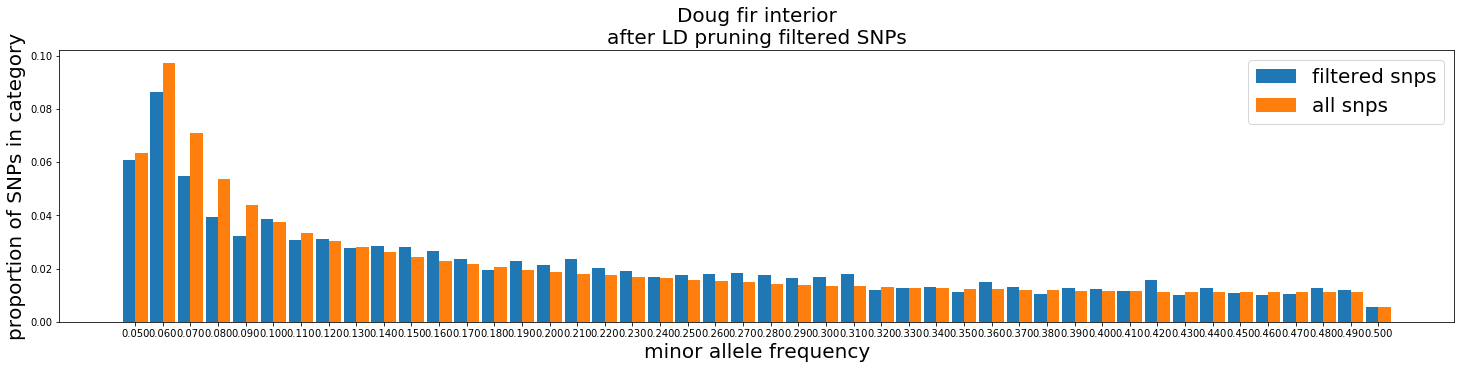

In [56]:
# compare MAF spectrum between rdpruned and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter LD pruning filtered SNPs')

In [58]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

# create infiles to baypass to estimate neutral structure

#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [12]:
lview,dview = get_client()

56 56


In [3]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [4]:
fs(baydir, bnames=True, dirs=False)

['lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3247.pkl']

In [6]:
prunedloci = pklload(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3247.pkl'))
len(prunedloci)

4295

In [10]:
linenums

{'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt': 2609583}

In [13]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

261
261


In [15]:
# get the returns, reduce to pruned loci
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
reduced = snps[snps['locus'].isin(prunedloci)].copy()
print(reduced.shape)
reduced.head()

(4295, 351)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p86.GT,DF_p86.GQ,DF_p86.SDP,DF_p86.DP,DF_p86.FREQ,DF_p86.PVAL,DF_p86.AD,DF_p86.RD,DF_p87.GT,DF_p87.GQ,DF_p87.SDP,DF_p87.DP,DF_p87.FREQ,DF_p87.PVAL,DF_p87.AD,DF_p87.RD,DF_p88.GT,DF_p88.GQ,DF_p88.SDP,DF_p88.DP,DF_p88.FREQ,DF_p88.PVAL,DF_p88.AD,DF_p88.RD,DF_p89.GT,DF_p89.GQ,DF_p89.SDP,DF_p89.DP,DF_p89.FREQ,DF_p89.PVAL,DF_p89.AD,DF_p89.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,DF_p94.GT,DF_p94.GQ,DF_p94.SDP,DF_p94.DP,DF_p94.FREQ,DF_p94.PVAL,DF_p94.AD,DF_p94.RD,locus,MAF
jcf7190000000008-431360,jcf7190000000008,431360,G,A,0.265446,-10.0,SNP,PASS,52,8,79,0,0,G/A,22.0,39,39.0,17.95%,5.821900e-03,7.0,32.0,G/A,25.0,46,46.0,17.39%,2.803300e-03,8.0,38.0,G/G,19.0,21,21.0,NaN,1.158500e-01,3.0,18.0,G/A,37.0,36,36.0,30.56%,1.987900e-04,11.0,25.0,G/G,43.0,42,42.0,9.52%,...,G/A,61.0,55,55.0,32.73%,7.224200e-07,18.0,37.0,G/A,29.0,40,40.0,22.5%,1.179100e-03,9.0,31.0,G/A,29.0,45,45.0,20%,1.254700e-03,9.0,36.0,G/A,34.0,27,27.0,37.04%,3.525300e-04,10.0,17.0,G/A,39.0,46,46.0,26.09%,1.072400e-04,12.0,34.0,G/A,55.0,46,46.0,34.78%,3.144600e-06,16.0,30.0,jcf7190000000008-431360,0.265446
jcf7190000000056-6513,jcf7190000000056,6513,C,T,0.347619,-10.0,SNP,PASS,36,4,83,0,0,C/C,35.0,35,35.0,11.43%,5.710600e-02,4.0,31.0,C/T,72.0,44,44.0,45.45%,5.728600e-08,20.0,24.0,C/T,39.0,24,24.0,45.83%,1.104700e-04,11.0,13.0,C/T,41.0,34,34.0,35.29%,7.530200e-05,12.0,22.0,C/T,44.0,41,41.0,31.71%,...,C/T,33.0,35,35.0,28.57%,4.627600e-04,10.0,25.0,C/T,47.0,45,45.0,31.11%,1.846200e-05,14.0,31.0,C/T,39.0,44,44.0,27.27%,1.027000e-04,12.0,32.0,C/T,23.0,23,23.0,30.43%,4.580300e-03,7.0,16.0,C/T,39.0,46,46.0,26.09%,1.072400e-04,12.0,34.0,C/T,15.0,27,27.0,NaN,2.552700e-02,5.0,22.0,jcf7190000000056-6513,0.347619
jcf7190000000070-125991,jcf7190000000070,125991,G,C,0.053856,-10.0,SNP,PASS,97,57,30,0,0,G/C,18.0,113,113.0,NaN,1.459700e-02,6.0,107.0,G/C,24.0,142,142.0,5.63%,3.530000e-03,8.0,134.0,G/C,15.0,51,51.0,NaN,2.820300e-02,5.0,46.0,G/G,158.0,106,106.0,2.83%,1.232200e-01,3.0,103.0,G/G,159.0,112,112.0,3.57%,...,G/G,164.0,88,88.0,0%,1.000000e+00,0.0,88.0,G/G,152.0,107,107.0,3.74%,6.074400e-02,4.0,103.0,G/G,126.0,82,82.0,2.44%,2.484700e-01,2.0,80.0,G/G,128.0,94,94.0,4.26%,6.050000e-02,4.0,90.0,G/G,138.0,93,93.0,3.23%,1.229700e-01,3.0,90.0,G/C,21.0,90,90.0,7.78%,6.921700e-03,7.0,83.0,jcf7190000000070-125991,0.053856
jcf7190000000084-68476,jcf7190000000084,68476,C,A,0.218836,-10.0,SNP,PASS,62,7,80,0,0,C/A,25.0,61,61.0,13.11%,3.045000e-03,8.0,53.0,C/A,106.0,97,97.0,31.96%,2.478200e-11,31.0,66.0,C/C,38.0,26,26.0,3.85%,5.000000e-01,1.0,25.0,C/A,67.0,73,73.0,27.4%,1.905000e-07,20.0,53.0,C/A,48.0,72,72.0,20.83%,...,C/A,46.0,50,50.0,28%,2.122400e-05,14.0,36.0,C/A,52.0,71,71.0,22.54%,5.805500e-06,16.0,55.0,C/A,42.0,60,60.0,21.67%,5.899100e-05,13.0,47.0,C/A,32.0,55,55.0,18.18%,6.180000e-04,10.0,45.0,C/A,56.0,66,66.0,25.76%,2.340800e-06,17.0,49.0,C/A,39.0,53,53.0,22.64%,1.193900e-04,12.0,41.0,jcf7190000000084-68476,0.218836
jcf7190000000090-26387,jcf7190000000090,26387,T,A,0.520637,-10.0,SNP,PASS,107,0,86,1,0,T/A,154.0,89,89.0,47.19%,3.745800e-16,42.0,47.0,T/A,255.0,195,195.0,38.97%,1.404300e-27,76.0,119.0,T/A,255.0,83,83.0,74.7%,8.833600e-28,62.0,21.0,T/A,250.0,79,79.0,73.42%,8.817800e-26,58.0,21.0,T/A,181.0,111,111.0,45.05%,...,T/A,109.0,65,65.0,46.15%,1.151900e-11,30.0,35.0,T/A,201.0,108,108.0,50%,7.041900e-21,54.0,54.0,T/A,153.0,90,90.0,46.67%,4.121200e-16,42.0,48.0,T/A,201.0,131,131.0,42.75%,7.300800e-21,56.0,75.0,T/A,164.0,65,65.0,63.08%,3.393300e-17,41.0,24.0,T/A,101.0,79,79.0,36.71%,7.895400e-11,29.0,50.0,jcf71

In [16]:
len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

True

In [17]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
#     assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm_notebook(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [21]:
# get the gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=42)
neutral_read_counts.head()

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p85-major,DF_p85-minor,DF_p86-major,DF_p86-minor,DF_p87-major,DF_p87-minor,DF_p88-major,DF_p88-minor,DF_p89-major,DF_p89-minor,DF_p9-major,DF_p9-minor,DF_p94-major,DF_p94-minor
jcf7190000004922-46795,72,22,105,25,64,15,93,23,103,13,86,22,111,23,65,37,0,0,51,13,49,17,97,20,36,10,54,13,38,9,63,21,118,29,67,13,71,22,109,22,96,19,103,23,58,19,111,35,91,25,93,37,96,32,128,24,50,19,61,10,133,41,133,31,147,36,118,25,65,13,82,20,87,23,76,25,71,32,54,14,73,31,123,19
jcf7190000168302-2649,316,16,477,40,159,15,371,25,396,35,368,24,400,41,264,20,200,12,281,24,230,17,388,24,158,14,211,19,177,17,292,20,330,34,289,29,254,22,384,23,418,35,339,31,303,29,436,31,365,24,384,23,362,34,387,33,260,23,383,22,400,32,446,34,394,31,407,28,322,26,372,29,290,25,404,20,308,17,243,13,360,27,301,15
jcf7190000243153-2724,0,0,67,11,19,9,39,14,33,11,22,4,38,14,37,16,18,8,37,7,0,0,0,0,27,8,27,11,39,7,0,0,25,4,41,7,31,8,0,0,30,3,49,8,22,11,50,17,32,7,0,0,0,0,40,7,34,8,33,2,32,7,37,14,46,9,48,10,34,10,32,10,16,7,0,0,30,13,0,0,33,8,31,9
jcf7190000076552-2401,0,0,62,19,19,9,0,0,57,16,60,8,0,0,63,11,0,0,42,2,48,1,65,12,22,2,27,2,33,3,0,0,48,13,43,9,36,8,41,3,56,10,65,7,48,17,75,26,49,21,45,16,74,3,0,0,35,3,84,0,102,13,48,12,50,16,75,0,53,7,34,20,47,8,77,1,51,2,44,1,50,12,39,7
jcf7190000266316-165308,82,10,93,14,40,6,92,10,75,40,90,16,85,49,38,65,35,5,76,9,59,35,56,62,8,27,24,39,29,19,41,60,99,37,56,53,64,8,76,15,88,23,51,94,55,8,105,13,107,1,76,21,86,32,132,6,57,13,9,111,139,5,99,15,119,12,68,48,59,39,70,39,75,44,97,32,41,42,30,63,55,48,66,18


In [22]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [23]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [24]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

42


In [32]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'interior_neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'interior_neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

In [26]:
DIR

'/data/projects/pool_seq/DF_datasets'

In [27]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'DF_pooled_GEA/DF_pooled/pkl_files/ploidy.pkl'))['DF_pooled']
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

DF_p1 80
DF_p10 80
DF_p11 80
DF_p12 80
DF_p13 80


In [28]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p85,DF_p86,DF_p87,DF_p88,DF_p89,DF_p9,DF_p94
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80,80,80,80,80,80,80


In [29]:
poolsizefile.shape

(1, 42)

In [30]:
neutral_read_counts.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p85-major,DF_p85-minor,DF_p86-major,DF_p86-minor,DF_p87-major,DF_p87-minor,DF_p88-major,DF_p88-minor,DF_p89-major,DF_p89-minor,DF_p9-major,DF_p9-minor,DF_p94-major,DF_p94-minor
jcf7190000004922-46795,72,22,105,25,64,15,93,23,103,13,86,22,111,23,65,37,0,0,51,13,49,17,97,20,36,10,54,13,38,9,63,21,118,29,67,13,71,22,109,22,96,19,103,23,58,19,111,35,91,25,93,37,96,32,128,24,50,19,61,10,133,41,133,31,147,36,118,25,65,13,82,20,87,23,76,25,71,32,54,14,73,31,123,19
jcf7190000168302-2649,316,16,477,40,159,15,371,25,396,35,368,24,400,41,264,20,200,12,281,24,230,17,388,24,158,14,211,19,177,17,292,20,330,34,289,29,254,22,384,23,418,35,339,31,303,29,436,31,365,24,384,23,362,34,387,33,260,23,383,22,400,32,446,34,394,31,407,28,322,26,372,29,290,25,404,20,308,17,243,13,360,27,301,15
jcf7190000243153-2724,0,0,67,11,19,9,39,14,33,11,22,4,38,14,37,16,18,8,37,7,0,0,0,0,27,8,27,11,39,7,0,0,25,4,41,7,31,8,0,0,30,3,49,8,22,11,50,17,32,7,0,0,0,0,40,7,34,8,33,2,32,7,37,14,46,9,48,10,34,10,32,10,16,7,0,0,30,13,0,0,33,8,31,9
jcf7190000076552-2401,0,0,62,19,19,9,0,0,57,16,60,8,0,0,63,11,0,0,42,2,48,1,65,12,22,2,27,2,33,3,0,0,48,13,43,9,36,8,41,3,56,10,65,7,48,17,75,26,49,21,45,16,74,3,0,0,35,3,84,0,102,13,48,12,50,16,75,0,53,7,34,20,47,8,77,1,51,2,44,1,50,12,39,7
jcf7190000266316-165308,82,10,93,14,40,6,92,10,75,40,90,16,85,49,38,65,35,5,76,9,59,35,56,62,8,27,24,39,29,19,41,60,99,37,56,53,64,8,76,15,88,23,51,94,55,8,105,13,107,1,76,21,86,32,132,6,57,13,9,111,139,5,99,15,119,12,68,48,59,39,70,39,75,44,97,32,41,42,30,63,55,48,66,18


In [33]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'interior_poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

In [17]:
poolsizefile = pd.read_table(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'))
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p85,DF_p86,DF_p87,DF_p88,DF_p89,DF_p9,DF_p94
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80,80,80,80,80,80,80


#### <center> create random runs

#### estimate covariance matrix (run in bash)
```bash
cd /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/baypass
mkdir neutral_runs
cd neutral_runs

export gfile="/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/baypass/neutral_gfile_noheaderidx.txt"

export poolsizefile="/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/baypass/poolsizefile_noheaderidx.txt"



# These commands took about 7 hours each to complete


# chain 1
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_1 > chain_1_stdout.txt &

# chain 2
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_2 > chain_2_stdout.txt &

# chain 3
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_3 > chain_3_stdout.txt &

# chain 4
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_4 > chain_4_stdout.txt &

# chain 5
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_5 > chain_5_stdout.txt &

```

# look at covariance matrices output from chains

In [ ]:
from pythonimports import *

In [ ]:
baydir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/baypass'

In [ ]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs_nval_30000_thr_6')
mfiles = fs(ndir, 'mat_omega.out')
mfiles

In [ ]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

In [ ]:
np.sqrt(7569)  # num pops

In [ ]:
from scipy.stats import pearsonr

In [ ]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

In [ ]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

In [ ]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

In [ ]:
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

In [ ]:
avg = summatrix / len(mats)
avg.shape

In [ ]:
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

In [ ]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

#### make sure pops are in same order as gfile

In [ ]:
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'))
poolsizefile

In [ ]:
gfile = pd.read_table(op.join(baydir, 'interior_neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

In [ ]:
list(poolsizefile.columns) == gfilecols

In [ ]:
# now apply to avgmat
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

In [ ]:
# save avgmatrix
avgmat.to_csv(op.join(baydir, 'interior_neutral_omegafile_HEADERIDX.txt'), sep='\t', index=True, header=True)
avgmat.to_csv(op.join(baydir, 'interior_neutral_omegafile_noheaderidx.txt'), sep='\t', index=False, header=False)

# make efile

In [35]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [37]:
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p85,DF_p86,DF_p87,DF_p88,DF_p89,DF_p9,DF_p94
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80,80,80,80,80,80,80


In [38]:
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/df_std_env-19variables.txt')
envdata

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
0,1,DF_p1,FDC,-126.63,49.78,-1.291837,0.642273,-0.351203,1.051691,-1.443853,3.058223,3.763300,-1.308553,-0.982819,-0.948176,0.115574,1.163143,-1.134312,1.021369,1.099211,-0.018522,1.190196,-0.816847,-0.573470,-1.758076
1,2,DF_p2,FDC,-122.73,50.32,-0.543644,-0.130593,0.022847,-0.233176,0.291294,-0.358888,-0.472262,-0.174552,-0.008026,0.005229,-0.140720,-0.155659,-0.199673,-0.228767,-0.023166,0.454869,-0.168208,-0.067660,-0.233095,0.124388
2,3,DF_p3,FDI,-115.62,50.54,1.700937,-1.642723,-1.379842,-1.441336,1.054759,-0.817183,0.263025,0.124412,-0.581866,1.845937,-1.374266,-1.421709,1.482677,-1.435795,-1.489127,0.083687,-1.505049,-1.092863,-0.945955,-0.864381
3,4,DF_p4,FDI,-122.33,52.04,0.262103,-0.869856,-0.491472,-1.153679,1.147301,-1.054945,-0.694380,1.608922,0.087614,1.024737,-0.663727,-0.929356,0.688234,-0.961605,-0.847769,-0.518811,-1.170839,-0.185953,-0.624847,0.396934
4,5,DF_p5,FDI,-119.05,49.02,0.153903,-0.164196,0.630678,-0.578365,1.008489,-1.119267,-0.885861,2.732614,0.554780,0.307776,0.128076,-0.507339,0.127451,-0.530524,-0.343845,-0.782404,-0.588666,0.918113,0.235722,1.328658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,94,DF_p94,FDI,-117.20,51.40,0.522244,-1.172282,-0.678497,-1.249565,1.170436,-0.802251,-0.548854,0.299667,-0.076077,1.367963,-0.895017,-0.982108,0.688234,-1.004713,-0.870675,0.444110,-1.181620,-0.698554,-0.862467,0.010300
84,95,DF_p95,FDC,-123.89,43.40,-1.317161,1.448742,0.350141,1.569474,-1.721477,0.651888,-0.242485,-0.659079,-0.114701,-1.154111,1.384542,1.743416,-1.835291,1.754207,1.855097,-1.126689,1.599873,0.523804,0.967849,0.149741
85,96,DF_p96,FDC,-122.81,46.25,-1.179033,1.112714,0.443653,1.128400,-1.143094,0.287779,0.178774,-0.504443,-0.326213,-1.034618,0.928214,1.127975,-0.713724,0.892044,0.824343,-0.970685,1.093167,0.720958,0.865094,-0.084774
86,97,DF_p97,FDC,-122.49,44.13,-0.967237,1.482345,1.238510,1.262640,-0.911741,0.110893,-0.280781,-0.287952,0.048990,-1.082924,1.672092,1.251064,-0.853920,1.064477,0.984682,-1.083653,1.179415,1.785592,1.744930,0.903995


In [39]:
# double check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

MAT -3.027880976250427e-17 0.9943019479194252
MWMT 5.551115123125783e-17 0.9943019479194254
MCMT -3.7343865373755267e-16 0.9943019479194254
TD 4.945538927875697e-16 0.9943019479194257
MAP 1.3625464393126921e-16 0.9943019479194254
MSP 7.569702440626067e-18 0.9943019479194252
AHM 6.055761952500853e-17 0.994301947919426
SHM 1.0092936587501423e-17 0.9943019479194254
DD_0 -2.0185873175002846e-16 0.9943019479194254
DD5 -3.6334571715005125e-16 0.9943019479194255
NFFD -1.8167285857502563e-16 0.9943019479194248
bFFP -7.87249053825111e-16 0.9943019479194257
eFFP -4.440892098500626e-16 0.994301947919425
FFP 8.074349270001139e-17 0.9943019479194252
PAS 1.2111523905001707e-16 0.9943019479194257
EMT 4.0371746350005693e-17 0.9943019479194254
EXT -1.2918958832001822e-15 0.9943019479194253
Eref 3.0783456591879343e-16 0.9943019479194255
CMD -4.289498049688105e-17 0.9943019479194252


In [41]:
# convert jp envdata to efile, making sure to order pops in same order as other files
envdata.index = envdata['our_id'].tolist()
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p18,0.037421,0.770947,-0.271531,0.707730,-0.586313,-0.418647,0.279049,0.080257,-0.083755,0.169750,-0.366667,0.220915,-0.487416,-0.366751,-0.034661,-0.200551,0.957544,0.466920,0.656802
DF_p19,0.608670,1.519048,0.188720,0.522647,-0.775833,0.025589,1.052231,-0.103666,-0.521050,0.805276,0.002598,-0.199673,-0.185659,-0.000260,-0.943787,0.068974,1.825023,1.115558,0.511022
DF_p20,-0.433019,0.350141,-0.501656,0.777136,-0.999812,-0.548854,1.547068,0.111524,0.335743,-0.236570,-0.718347,0.641502,-0.832281,-0.756147,-0.604882,-0.470075,0.405511,-0.098230,0.694832
DF_p3,-1.642723,-1.379842,-1.441336,1.054759,-0.817183,0.263025,0.124412,-0.581866,1.845937,-1.374266,-1.421709,1.482677,-1.435795,-1.489127,0.083687,-1.505049,-1.092863,-0.945955,-0.864381
DF_p33,-1.877943,-1.707136,-1.575576,1.054759,-0.505910,0.286003,-0.535370,-0.631526,2.194247,-1.588886,-1.509629,1.435945,-1.608227,-1.557844,1.428549,-1.612859,-1.290018,-1.138620,-0.991146


In [42]:
# compare to above to make sure it copied over OK
envdata.loc[poolsizefile.columns.tolist(), :].head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p18,18,DF_p18,FDI,-116.83,48.33,0.084839,0.037421,0.770947,-0.271531,0.707730,-0.586313,-0.418647,0.279049,0.080257,-0.083755,0.169750,-0.366667,0.220915,-0.487416,-0.366751,-0.034661,-0.200551,0.957544,0.466920,0.656802
DF_p19,19,DF_p19,FDI,-116.00,45.83,-0.230554,0.608670,1.519048,0.188720,0.522647,-0.775833,0.025589,1.052231,-0.103666,-0.521050,0.805276,0.002598,-0.199673,-0.185659,-0.000260,-0.943787,0.068974,1.825023,1.115558,0.511022
DF_p20,20,DF_p20,FDI,-114.50,48.08,1.277345,-0.433019,0.350141,-0.501656,0.777136,-0.999812,-0.548854,1.547068,0.111524,0.335743,-0.236570,-0.718347,0.641502,-0.832281,-0.756147,-0.604882,-0.470075,0.405511,-0.098230,0.694832
DF_p3,3,DF_p3,FDI,-115.62,50.54,1.700937,-1.642723,-1.379842,-1.441336,1.054759,-0.817183,0.263025,0.124412,-0.581866,1.845937,-1.374266,-1.421709,1.482677,-1.435795,-1.489127,0.083687,-1.505049,-1.092863,-0.945955,-0.864381
DF_p33,33,DF_p33,FDI,-116.25,51.03,1.698635,-1.877943,-1.707136,-1.575576,1.054759,-0.505910,0.286003,-0.535370,-0.631526,2.194247,-1.588886,-1.509629,1.435945,-1.608227,-1.557844,1.428549,-1.612859,-1.290018,-1.138620,-0.991146


In [43]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p85,DF_p86,DF_p87,DF_p88,DF_p89,DF_p9,DF_p94
MAT,0.037421,0.608670,-0.433019,-1.642723,-1.877943,-1.743531,-0.634636,-1.340297,-1.709928,-1.474708,-0.567430,-0.869856,-1.575517,-0.970665,-1.474708,-0.735445,-0.399416,-0.668239,-1.205885,-1.239488,-1.609120,0.104627,-0.164196,-0.433019,0.709479,0.037421,-0.365813,-0.769048,-0.399416,-0.466622,-0.096990,-0.332210,-0.466622,-1.037871,-1.474708,-0.567430,-0.937062,-1.105077,-1.004268,-0.130593,-1.205885,-1.172282
MWMT,0.770947,1.519048,0.350141,-1.379842,-1.707136,-1.520111,-0.070666,-1.286329,-1.426598,-1.052548,0.022847,-0.491472,-2.174698,-0.818766,-1.146060,-0.678497,0.256628,-0.070666,-1.005791,-0.772010,-1.099304,0.911216,0.630678,0.022847,1.706073,0.770947,0.069603,-0.210935,0.069603,-0.257691,0.396897,0.396897,0.163116,-0.631741,-1.239573,-0.117422,-0.538229,-0.678497,-0.912279,0.583922,-0.912279,-0.678497
MCMT,-0.271531,0.188720,-0.501656,-1.441336,-1.575576,-1.307096,-1.057793,-1.307096,-1.613930,-1.556399,-1.057793,-1.153679,-1.096147,-1.115325,-1.556399,-1.000262,-0.750959,-0.846845,-0.846845,-1.249565,-1.690639,-0.386594,-0.578365,-0.309885,0.169543,-0.329062,-0.424948,-0.616719,-0.309885,-0.789313,-0.175645,-0.271531,-0.597542,-1.364627,-1.556399,-0.578365,-1.115325,-1.326273,-1.000262,-0.520833,-1.230387,-1.249565
TD,0.707730,0.522647,0.777136,1.054759,1.054759,0.823406,1.239842,0.939083,1.239842,1.355518,1.286112,1.147301,0.245024,0.939083,1.286112,0.869677,1.031624,1.008489,0.522647,1.124165,1.494330,0.892812,1.008489,0.360700,0.638324,0.777136,0.545783,0.638324,0.430106,0.846542,0.430106,0.522647,0.800271,1.332383,1.262977,0.661459,1.077895,1.262977,0.754000,0.892812,1.054759,1.170436
MAP,-0.586313,-0.775833,-0.999812,-0.817183,-0.505910,-0.732186,-1.041162,-1.116970,-1.149131,-1.133050,-0.971096,-1.054945,-0.855087,-0.786170,-0.897586,-1.166360,-1.169806,-0.431250,0.255618,-0.574826,-0.503613,-0.963056,-1.119267,-0.827520,-0.757455,-0.605839,-0.450777,-0.280783,-0.090114,-0.590907,-0.387603,-0.541517,-0.480641,-0.530031,-0.883802,-0.369225,-0.891842,-0.848195,-0.704619,-0.678201,-0.918260,-0.802251


In [44]:
# save
efile.to_csv(op.join(baydir, 'interior_efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'interior_efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

In [45]:
# save a separate efile for each env so I can run the MCMC algorithm for GEA
envdir = makedir(op.join(baydir, 'individual_efiles'))
for env in efile.index:
    df = pd.DataFrame(efile.loc[env, :]).T
    df.to_csv(op.join(envdir, 'interior_%s_HEADERIDX.txt' % env), sep='\t', index=True, header=True)
    df.to_csv(op.join(envdir, 'interior_%s_noheaderidx.txt' % env), sep='\t', index=False, header=False)
df

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p85,DF_p86,DF_p87,DF_p88,DF_p89,DF_p9,DF_p94
CMD,0.656802,0.511022,0.694832,-0.864381,-0.991146,-0.820013,0.504684,0.485669,0.11805,0.086359,0.251154,0.396934,-0.293937,-0.534791,-0.243231,1.132172,1.062451,-0.813674,-1.498207,-0.097451,-0.889734,0.853289,1.328658,1.113157,0.751876,0.656802,-0.002377,0.124388,-0.781983,0.663141,0.59342,-0.21154,0.44764,-0.718601,-0.300275,-0.750292,-0.363658,-0.382673,-0.839028,-0.021392,-0.179848,0.0103


# create gfiles for GEA from "SNP" files (ADP < 1000)

In [1]:
linenums

NameError: name 'linenums' is not defined

In [15]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

53
53


In [16]:
# get job returns
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
snps.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p86.GT,DF_p86.GQ,DF_p86.SDP,DF_p86.DP,DF_p86.FREQ,DF_p86.PVAL,DF_p86.AD,DF_p86.RD,DF_p87.GT,DF_p87.GQ,DF_p87.SDP,DF_p87.DP,DF_p87.FREQ,DF_p87.PVAL,DF_p87.AD,DF_p87.RD,DF_p88.GT,DF_p88.GQ,DF_p88.SDP,DF_p88.DP,DF_p88.FREQ,DF_p88.PVAL,DF_p88.AD,DF_p88.RD,DF_p89.GT,DF_p89.GQ,DF_p89.SDP,DF_p89.DP,DF_p89.FREQ,DF_p89.PVAL,DF_p89.AD,DF_p89.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,DF_p94.GT,DF_p94.GQ,DF_p94.SDP,DF_p94.DP,DF_p94.FREQ,DF_p94.PVAL,DF_p94.AD,DF_p94.RD,locus,MAF
jcf7190000000000-77602,jcf7190000000000,77602,G,T,0.822964,-10.0,SNP,PASS,11,6,34,26,21,G/T,84.0,24,24.0,79.17%,3.682600e-09,19.0,5.0,T/T,121.0,26,26.0,92.31%,7.622200e-13,24.0,2.0,./.,NaN,2,NaN,NaN,NaN,NaN,NaN,T/T,87.0,20,20.0,90%,1.675800e-09,18.0,2.0,./.,NaN,5,NaN,NaN,...,G/T,29.0,9,9.0,77.78%,1.131200e-03,7.0,2.0,T/T,44.0,12,12.0,83.33%,3.365200e-05,10.0,2.0,T/T,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,T/T,52.0,15,15.0,80%,5.260500e-06,12.0,3.0,T/T,39.0,11,11.0,81.82%,0.000111,9.0,2.0,G/T,31.0,12,12.0,66.67%,6.730400e-04,8.0,4.0,jcf7190000000000-77602,0.177036
jcf7190000000000-77657,jcf7190000000000,77657,T,C,0.808995,-10.0,SNP,PASS,16,5,51,26,5,C/C,160.0,43,43.0,81.4%,9.593300e-17,35.0,8.0,C/C,128.0,34,34.0,82.35%,1.349000e-13,28.0,6.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,71.0,20,20.0,80%,7.708600e-08,16.0,4.0,C/C,47.0,11,11.0,90.91%,...,C/C,68.0,18,18.0,83.33%,1.465500e-07,15.0,3.0,C/C,81.0,17,17.0,94.12%,7.713400e-09,16.0,1.0,C/C,60.0,15,15.0,86.67%,8.767500e-07,13.0,2.0,T/C,79.0,23,23.0,78.26%,1.193700e-08,18.0,5.0,T/C,49.0,17,17.0,70.59%,0.000011,12.0,5.0,T/C,60.0,18,18.0,77.78%,8.060500e-07,14.0,4.0,jcf7190000000000-77657,0.191005
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.804214,-10.0,SNP,PASS,13,2,49,28,8,T/C,103.0,32,32.0,75%,4.196400e-11,24.0,8.0,C/C,126.0,27,27.0,92.59%,2.085300e-13,25.0,2.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,T/C,29.0,9,9.0,77.78%,...,C/C,71.0,18,18.0,88.24%,7.327700e-08,15.0,3.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,./.,NaN,7,NaN,NaN,NaN,NaN,NaN,C/C,105.0,25,25.0,88%,2.591600e-11,22.0,3.0,T/C,18.0,9,9.0,NaN,0.014706,5.0,4.0,C/C,55.0,14,14.0,85.71%,2.991300e-06,12.0,2.0,jcf7190000000000-77738,0.195786
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.933934,-10.0,SNP,PASS,12,1,28,50,8,C/C,127.0,29,29.0,89.66%,1.649600e-13,26.0,3.0,C/C,117.0,21,21.0,100%,1.857800e-12,21.0,0.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,58.0,11,11.0,100%,...,C/C,71.0,17,17.0,88.24%,7.327700e-08,15.0,2.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,C/C,36.0,9,9.0,88.89%,2.056800e-04,8.0,1.0,C/C,86.0,18,18.0,94.44%,2.093600e-09,17.0,1.0,C/C,52.0,10,10.0,100%,0.000005,10.0,0.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,jcf7190000000000-77764,0.066066
jcf7190000000000-77784,jcf7190000000000,77784,A,G,0.904187,-10.0,SNP,PASS,11,0,32,38,17,G/G,107.0,27,27.0,85.19%,1.616100e-11,23.0,4.0,G/G,111.0,20,20.0,100%,7.254400e-12,20.0,0.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,G/G,64.0,12,12.0,100%,3.698000e-07,12.0,0.0,G/G,46.0,9,9.0,100%,...,G/G,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,G/G,41.0,8,8.0,100%,7.770000e-05,8.0,0.0,G/G,46.0,9,9.0,100%,2.056800e-05,9.0,0.0,G/G,34.0,10,10.0,80%,3.572300e-04,8.0,2.0,G/G,46.0,9,9.0,100%,0.000021,9.0,0.0,A/G,37.0,12,12.0,75%,1.682600e-04,9.0,3.0,jcf7190000000000-77784,0.095813


In [17]:
snps.shape

(2609583, 351)

In [18]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2609304, 351), (2609583, 351))

In [35]:
# test function
x = get_counts(reduced.index[:5])
x.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p85-major,DF_p85-minor,DF_p86-major,DF_p86-minor,DF_p87-major,DF_p87-minor,DF_p88-major,DF_p88-minor,DF_p89-major,DF_p89-minor,DF_p9-major,DF_p9-minor,DF_p94-major,DF_p94-minor
jcf7190000000000-77602,19,5,24,2,0,0,18,2,0,0,13,0,9,3,14,1,9,2,21,3,16,3,14,2,0,0,0,0,6,2,13,6,15,1,11,2,12,1,0,0,6,3,11,4,21,2,13,5,7,8,0,0,11,2,7,1,0,0,0,0,13,0,21,5,14,6,0,0,12,2,9,2,7,2,10,2,10,0,12,3,9,2,8,4
jcf7190000000000-77657,35,8,28,6,0,0,16,4,10,1,19,5,9,4,14,2,7,4,20,4,21,2,10,2,0,0,8,6,7,2,15,8,16,5,15,2,15,6,0,0,9,2,14,0,21,4,22,3,13,4,8,2,16,4,9,4,10,1,0,0,16,6,22,8,17,2,16,2,19,2,17,2,15,3,16,1,13,2,18,5,12,5,14,4
jcf7190000000000-77738,24,8,25,2,0,0,16,2,7,2,12,6,6,2,11,2,9,1,15,2,10,2,9,2,0,0,6,5,6,3,10,7,10,5,11,4,6,2,0,0,7,3,11,0,15,3,15,5,9,3,6,4,12,1,11,3,9,3,0,0,15,2,13,4,13,1,14,3,14,0,16,3,15,3,10,0,0,0,22,3,0,0,12,2
jcf7190000000000-77764,26,3,21,0,0,0,14,0,11,0,18,0,11,0,9,0,0,0,13,1,12,1,11,0,0,0,8,1,7,2,10,6,14,2,11,1,0,0,0,0,7,1,9,0,14,0,16,0,10,2,12,0,11,0,15,1,10,2,0,0,12,0,14,2,14,0,11,2,11,0,14,2,15,2,10,0,8,1,17,1,10,0,10,0
jcf7190000000000-77784,23,4,20,0,0,0,12,0,9,0,12,0,8,0,10,0,0,0,16,0,11,2,7,1,0,0,0,0,6,2,12,7,12,2,13,1,0,0,0,0,0,0,9,1,13,0,12,1,8,4,10,1,10,1,14,2,7,1,0,0,9,0,13,1,15,0,11,1,0,0,12,3,11,2,8,0,9,0,8,2,9,0,9,3


In [21]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

129

In [22]:
# restart engines
lview,dview = get_client()

15 15


In [24]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [25]:
# thresh to evenly distribute jobs
nrow(reduced) / len(lview)

173953.6

In [27]:
# send jobs to engines for get_counts()
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == 173954 or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, tosend))
        tosend = []
watch_async(jobs)

15
15


In [28]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [37]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [38]:
# make sure returns make sense
nrow(reduced) == luni(gfile.index)

True

In [39]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [40]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [41]:
jobs = []
files = [op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [ ]:
watch_async(jobs)

In [42]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [43]:
nrow(reduced)/10000

260.9304

In [44]:
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [45]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [49]:
# write small gfiles to parallelize baypass
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 10000 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        for bname in ['all_snps_ADP-lt-1000_gfile_HEADERIDX.txt',
                      'all_snps_ADP-lt-1000_gfile_noheaderidx.txt']:
            bname = bname.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
            smallpath = op.join(gfile_dir, bname)
            newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        tosend = []
        jobcount += 1
watch_async(newjobs)

522
522


In [62]:
smallgfile.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p85-major,DF_p85-minor,DF_p86-major,DF_p86-minor,DF_p87-major,DF_p87-minor,DF_p88-major,DF_p88-minor,DF_p89-major,DF_p89-minor,DF_p9-major,DF_p9-minor,DF_p94-major,DF_p94-minor
jcf7190016433988-100,29,2,32,1,0,0,22,2,23,1,22,0,29,3,42,2,12,0,26,3,32,3,31,3,14,0,39,1,27,4,39,1,51,3,34,2,28,1,21,0,34,4,29,3,0,0,50,0,35,1,23,1,28,2,30,0,0,0,56,0,48,9,29,3,38,3,49,1,28,3,28,0,47,4,37,2,24,0,0,0,50,1,31,2
jcf7190016433988-264,30,2,41,2,28,1,23,3,21,3,27,1,41,1,39,3,0,0,28,3,26,2,0,0,0,0,42,2,23,1,45,2,51,2,38,1,27,1,0,0,0,0,29,1,0,0,45,7,44,0,20,3,25,4,29,2,27,3,64,1,62,0,32,4,41,1,51,0,27,1,28,3,45,2,37,2,24,1,46,2,42,2,32,0
jcf7190016434209-92,40,3,53,3,30,1,38,3,39,3,24,3,50,7,50,3,22,2,37,0,34,7,27,2,13,0,28,1,24,3,31,1,57,3,21,2,35,3,26,4,0,0,51,3,0,0,32,2,40,4,40,2,0,0,30,0,21,2,30,2,66,7,17,2,0,0,49,3,32,3,0,0,46,4,36,8,0,0,34,3,0,0,0,0
jcf7190016434395-149,7,1,18,0,10,1,12,0,11,0,9,1,10,7,11,6,0,0,9,0,0,0,0,0,0,0,12,5,0,0,15,1,12,1,14,2,14,0,8,0,11,5,13,2,10,2,11,0,17,2,13,1,11,0,11,0,0,0,9,2,12,2,9,1,18,0,14,1,0,0,12,0,0,0,17,3,8,4,8,4,0,0,13,1
jcf7190016434623-59,9,21,24,32,6,7,14,13,24,21,17,17,19,15,19,18,7,13,11,9,11,8,23,15,0,0,16,9,8,8,16,9,22,19,14,17,19,20,13,10,35,14,20,14,5,7,12,18,21,12,29,27,24,23,23,14,5,16,8,20,40,33,10,12,29,35,21,23,12,15,17,9,20,17,18,15,16,13,16,14,19,8,28,10


In [63]:
# compare columns to small gfile
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p85,DF_p86,DF_p87,DF_p88,DF_p89,DF_p9,DF_p94
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80,80,80,80,80,80,80


In [4]:
gfile_dir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [8]:
from pythonimports import *

In [11]:
smallgfile = pd.read_table(fs(gfile_dir, 'HEADER')[0], index_col=0)
smallgfile.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p85-major,DF_p85-minor,DF_p86-major,DF_p86-minor,DF_p87-major,DF_p87-minor,DF_p88-major,DF_p88-minor,DF_p89-major,DF_p89-minor,DF_p9-major,DF_p9-minor,DF_p94-major,DF_p94-minor
jcf7190000000000-77602,19,5,24,2,0,0,18,2,0,0,13,0,9,3,14,1,9,2,21,3,16,3,14,2,0,0,0,0,6,2,13,6,15,1,11,2,12,1,0,0,6,3,11,4,21,2,13,5,7,8,0,0,11,2,7,1,0,0,0,0,13,0,21,5,14,6,0,0,12,2,9,2,7,2,10,2,10,0,12,3,9,2,8,4
jcf7190000000000-77657,35,8,28,6,0,0,16,4,10,1,19,5,9,4,14,2,7,4,20,4,21,2,10,2,0,0,8,6,7,2,15,8,16,5,15,2,15,6,0,0,9,2,14,0,21,4,22,3,13,4,8,2,16,4,9,4,10,1,0,0,16,6,22,8,17,2,16,2,19,2,17,2,15,3,16,1,13,2,18,5,12,5,14,4
jcf7190000000000-77738,24,8,25,2,0,0,16,2,7,2,12,6,6,2,11,2,9,1,15,2,10,2,9,2,0,0,6,5,6,3,10,7,10,5,11,4,6,2,0,0,7,3,11,0,15,3,15,5,9,3,6,4,12,1,11,3,9,3,0,0,15,2,13,4,13,1,14,3,14,0,16,3,15,3,10,0,0,0,22,3,0,0,12,2
jcf7190000000000-77764,26,3,21,0,0,0,14,0,11,0,18,0,11,0,9,0,0,0,13,1,12,1,11,0,0,0,8,1,7,2,10,6,14,2,11,1,0,0,0,0,7,1,9,0,14,0,16,0,10,2,12,0,11,0,15,1,10,2,0,0,12,0,14,2,14,0,11,2,11,0,14,2,15,2,10,0,8,1,17,1,10,0,10,0
jcf7190000000000-77784,23,4,20,0,0,0,12,0,9,0,12,0,8,0,10,0,0,0,16,0,11,2,7,1,0,0,0,0,6,2,12,7,12,2,13,1,0,0,0,0,0,0,9,1,13,0,12,1,8,4,10,1,10,1,14,2,7,1,0,0,9,0,13,1,15,0,11,1,0,0,12,3,11,2,8,0,9,0,8,2,9,0,9,3


In [12]:
smallcols = [col.split("-major")[0] for col in smallgfile.columns if 'major' in col]
len(smallcols)

42

In [19]:
all(smallcols == poolsizefile.columns)

True

In [20]:
# assert missing data looks right (<25%)
majorcols = [col for col in smallgfile if 'major' in col]
for locus in nb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break

100%|██████████| 10000/10000 [00:05<00:00, 1806.58it/s]


In [21]:
missingcount/len(majorcols)

0.0